In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


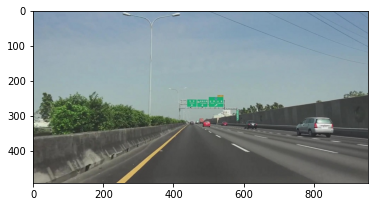

In [35]:
#%% Load pic 
P = './data'
F = 'test02.jpg'
img = cv2.imread(os.path.join(P, F))
img = img[:,:,[2,1,0]]
plt.imshow(img)

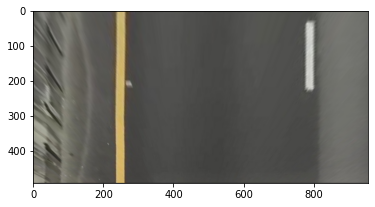

In [36]:
#%% Transform
src = np.float32(
            [[235, 490],  # Bottom left
             [375, 375],  # Top left
             [570, 375],  # Top right
             [810, 490]]) # Bottom right

dst = np.float32(
            [[235, 490],  # Bottom left
             [235, 0],  # Top left
             [810, 0],  # Top right
             [810, 490]]) # Bottom right  

img_size = (img.shape[1], img.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
img_warped = cv2.warpPerspective(img, M, img_size)  

plt.imshow(img_warped)

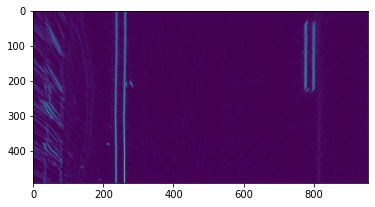

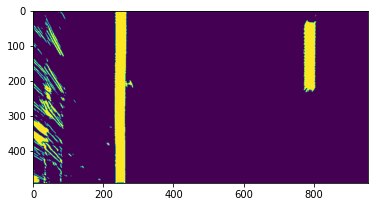

In [37]:
#%% Binary
gray_img =cv2.cvtColor(img_warped, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
abs_sobelx = np.absolute(sobelx)
# Scale result to 0-255
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
fig_0 = plt.figure(0)
plt.imshow(scaled_sobel)
sx_binary = np.zeros_like(scaled_sobel)
# Keep only derivative values that are in the margin of interest
sx_binary[(scaled_sobel >= 30) & (scaled_sobel <= 255)] = 1
# Detect pixels that are white in the grayscale image
white_binary = np.zeros_like(gray_img)
white_binary[(gray_img > 150) & (gray_img <= 255)] = 1
# Combine all pixels detected above
binary_warped = cv2.bitwise_or(sx_binary, white_binary)
fig_1 = plt.figure(1)
plt.imshow(binary_warped)

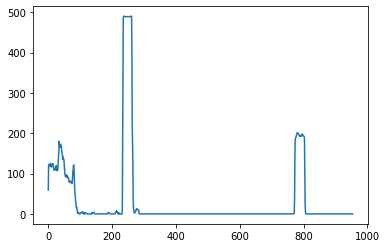

In [57]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped, axis=0)
plt.plot(np.arange(binary_warped.shape[1]), histogram)

In [58]:
midpoint = int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
print(leftx_base)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(rightx_base)

laneBase = [leftx_base, rightx_base]

236
780


In [56]:
nwindows = 9
margin = 40
minpixel = 50

for n_lane in range(len(laneBase)): 
    window_height = int(binary_warped.shape[0]//nwindows)
    x_point = []
    y_point = []
    laneCurrent = laneBase[n_lane]
    for n_window in range(nwindows):
        x_range = [laneCurrent - margin , laneCurrent + margin]
        if x_range[0] < 0:
            x_range[0] = 0
        if x_range[1] >= binary_warped.shape[1]:
            x_range[1] = binary_warped.shape[1] - 1

        win_y_low = binary_warped.shape[0] - (n_window+1)*window_height
        win_y_high = binary_warped.shape[0] - n_window*window_height

        window = binary_warped[win_y_low:win_y_high, x_range[0]:x_range[1]]

        y_nonzero, x_nonzero = np.nonzero(window)
        x_nonzero += x_range[0]
        y_nonzero += win_y_low

        if np.count_nonzero(window) > minpixel:
            x_point.extend(x_nonzero)
            y_point.extend(y_nonzero)
            laneCurrent = np.mean(x_nonzero, axis=0, dtype=np.int32)

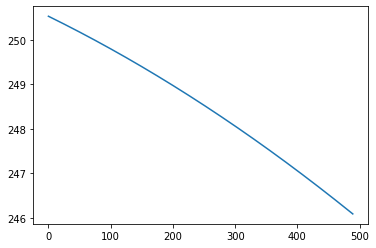

In [42]:
### Fit a second order polynomial to each with np.polyfit() ###
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)   

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



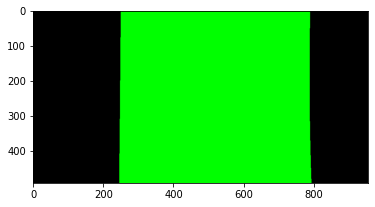

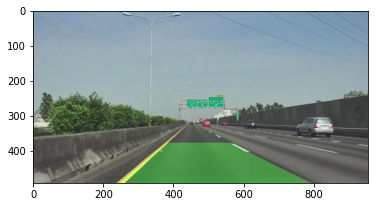

In [44]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))




# Draw the lane onto the warped blank image
AAA = cv2.fillPoly(color_warp, int([pts]), (0,255, 0))
fig_0 = plt.figure(0)
plt.imshow(AAA)


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))

# Combine the result with the original image
out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

fig_1 = plt.figure(1) 
plt.imshow(out_img)